In [1]:
print("Starting the training process...")

Starting the training process...


In [2]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from img2vec import grayscale2emb
import math
import os
import pandas as pd
from sklearn.pipeline import Pipeline
import joblib
from sklearn.model_selection import GridSearchCV

# Define the batch size for data processing
batch_size = 64

### read the data

In [3]:
train_data = pd.read_csv(os.path.join('..', '..', 'data', 'train.csv'))
val_data = pd.read_csv(os.path.join('..', '..', 'data', 'val.csv'))
test_data = pd.read_csv(os.path.join('..', '..', 'data', 'test.csv'))

### add the path of the images

In [4]:
def construct_img_path(row):
    return os.path.join("..", "..", "data", "faces", row['user_id'],
                        "coarse_tilt_aligned_face." + str(row['face_id']) + "." + row['original_image'])


train_data['img_path'] = train_data.apply(construct_img_path, axis=1)
val_data['img_path'] = val_data.apply(construct_img_path, axis=1)
test_data['img_path'] = test_data.apply(construct_img_path, axis=1)
train_data.head(5)

,user_id,face_id,original_image,age,gender,img_path
0,9855553@N08,1581,11658657103_4485e3f5ac_o.jpg,"(60, 100)",m,..\..\data\faces\9855553@N08\coarse_tilt_align...
1,114841417@N06,502,12059583524_606ca96139_o.jpg,"(15, 20)",m,..\..\data\faces\114841417@N06\coarse_tilt_ali...
2,66870968@N06,1227,11326189206_e08bdf6dfd_o.jpg,"(25, 32)",m,..\..\data\faces\66870968@N06\coarse_tilt_alig...
3,8187011@N06,988,11133041085_e2ee5e12cb_o.jpg,"(0, 2)",u,..\..\data\faces\8187011@N06\coarse_tilt_align...
4,114841417@N06,485,12059753735_7141b5443c_o.jpg,"(15, 20)",f,..\..\data\faces\114841417@N06\coarse_tilt_ali...


#### add column for check if the image exists
it will help us to detect if there is any missing image, or if there is any bug in the path construction

In [5]:
train_data['img_exists'] = train_data['img_path'].apply(os.path.exists)
val_data['img_exists'] = val_data['img_path'].apply(os.path.exists)
test_data['img_exists'] = test_data['img_path'].apply(os.path.exists)

train_data.head(5)

,user_id,face_id,original_image,age,gender,img_path,img_exists
0,9855553@N08,1581,11658657103_4485e3f5ac_o.jpg,"(60, 100)",m,..\..\data\faces\9855553@N08\coarse_tilt_align...,True
1,114841417@N06,502,12059583524_606ca96139_o.jpg,"(15, 20)",m,..\..\data\faces\114841417@N06\coarse_tilt_ali...,True
2,66870968@N06,1227,11326189206_e08bdf6dfd_o.jpg,"(25, 32)",m,..\..\data\faces\66870968@N06\coarse_tilt_alig...,True
3,8187011@N06,988,11133041085_e2ee5e12cb_o.jpg,"(0, 2)",u,..\..\data\faces\8187011@N06\coarse_tilt_align...,True
4,114841417@N06,485,12059753735_7141b5443c_o.jpg,"(15, 20)",f,..\..\data\faces\114841417@N06\coarse_tilt_ali...,True


### Filter out any rows where the image doesn't exist


In [6]:
train_data_filtered = train_data[train_data['img_exists'] == True]
val_data_filtered = val_data[val_data['img_exists'] == True]
test_data_filtered = test_data[test_data['img_exists'] == True]

In [7]:
def encode_gender_age(train_data, val_data, test_data, save_encoder=True, load_existing=True):
    """Encodes gender and age combinations into a single label, handling unseen labels."""
    
    # Check if encoder already exists and we want to load it
    encoder_path = 'gender_age_encoder.joblib'
    if load_existing and os.path.exists(encoder_path):
        print("Loading existing gender-age encoder...")
        gender_age_encoder = joblib.load(encoder_path)
        
        # Apply encoder to the datasets
        train_data['gender_age_combined'] = train_data['gender'].astype(str) + '_' + train_data['age'].astype(str)
        val_data['gender_age_combined'] = val_data['gender'].astype(str) + '_' + val_data['age'].astype(str)
        test_data['gender_age_combined'] = test_data['gender'].astype(str) + '_' + test_data['age'].astype(str)
        
        # Function to handle unseen labels
        def transform_with_unknown(data, encoder):
            known_classes = set(encoder.classes_)
            data['gender_age_label'] = data['gender_age_combined'].apply(
                lambda x: encoder.transform([x])[0] if x in known_classes else -1
            )  # assign -1 to unseen label.
            return data
        
        # Apply encoding to all datasets
        train_data = transform_with_unknown(train_data, gender_age_encoder)
        val_data = transform_with_unknown(val_data, gender_age_encoder)
        test_data = transform_with_unknown(test_data, gender_age_encoder)
        
    else:
        print("Creating new gender-age encoder...")
        # Create combined labels
        train_data['gender_age_combined'] = train_data['gender'].astype(str) + '_' + train_data['age'].astype(str)
        val_data['gender_age_combined'] = val_data['gender'].astype(str) + '_' + val_data['age'].astype(str)
        test_data['gender_age_combined'] = test_data['gender'].astype(str) + '_' + test_data['age'].astype(str)

        # Create and fit the encoder
        gender_age_encoder = LabelEncoder()
        train_data['gender_age_label'] = gender_age_encoder.fit_transform(train_data['gender_age_combined'])

        # Function to handle unseen labels
        def transform_with_unknown(data, encoder):
            known_classes = set(encoder.classes_)
            data['gender_age_label'] = data['gender_age_combined'].apply(
                lambda x: encoder.transform([x])[0] if x in known_classes else -1
            )  # assign -1 to unseen label.
            return data

        # Apply to validation and test
        val_data = transform_with_unknown(val_data, gender_age_encoder)
        test_data = transform_with_unknown(test_data, gender_age_encoder)
        
        # Save the encoder if requested
        if save_encoder:
            joblib.dump(gender_age_encoder, encoder_path)
            print(f"Saved encoder to {encoder_path}")

    # Clean up temporary columns
    train_data.drop('gender_age_combined', axis=1, inplace=True)
    val_data.drop('gender_age_combined', axis=1, inplace=True)
    test_data.drop('gender_age_combined', axis=1, inplace=True)

    num_classes = len(gender_age_encoder.classes_)
    print(f"Number of classes: {num_classes}")
    
    return train_data, val_data, test_data, num_classes, gender_age_encoder

# Usage
train_data, val_data, test_data, num_classes, gender_age_encoder = encode_gender_age(
    train_data_filtered, val_data_filtered, test_data_filtered, 
    save_encoder=True, 
    load_existing=True  # Set to False if you want to recreate the encoder
)

print("gender_age classes:", gender_age_encoder.classes_)

Loading existing gender-age encoder...
Number of classes: 20
gender_age classes: ['f_(0, 2)' 'f_(15, 20)' 'f_(25, 32)' 'f_(38, 43)' 'f_(4, 6)' 'f_(48, 53)'
 'f_(60, 100)' 'f_(8, 23)' 'm_(0, 2)' 'm_(15, 20)' 'm_(25, 32)'
 'm_(38, 43)' 'm_(4, 6)' 'm_(48, 53)' 'm_(60, 100)' 'm_(8, 23)' 'u_(0, 2)'
 'u_(25, 32)' 'u_(60, 100)' 'u_(8, 23)']


### Define a generator function to process images in batches

In [8]:
def image_batch_generator(image_paths, labels, batch_size):
    num_samples = len(image_paths)
    num_batches = math.ceil(num_samples / batch_size)

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, num_samples)

        batch_paths = image_paths[start_idx:end_idx]
        batch_features = grayscale2emb(batch_paths) / 255.0  # Normalize to [0,1]
        batch_labels = labels[start_idx:end_idx]

        yield batch_features, batch_labels


### Extract image paths and labels

In [9]:
train_image_paths = train_data['img_path'].tolist()
train_labels = train_data['gender_age_label'].values

val_image_paths = val_data['img_path'].tolist()
val_labels = val_data['gender_age_label'].values

test_image_paths = test_data['img_path'].tolist()
test_labels = test_data['gender_age_label'].values

### Print dataset sizes

In [10]:
print(f"Training samples: {len(train_image_paths)}")
print(f"Validation samples: {len(val_image_paths)}")
print(f"Test samples: {len(test_image_paths)}")
print(f"Number of classes: {num_classes}")


Training samples: 11856
Validation samples: 2964
Test samples: 3731
Number of classes: 20


### Extract features for training and validation


In [11]:
print("Extracting features for training data...")
print(f"Processing all {len(train_image_paths)} training samples")

Extracting features for training data...
Processing all 11856 training samples


### Define a function to extract features in batches


In [12]:
def extract_features_in_batches(image_paths, batch_size=64):
    """Extract features from images in batches to manage memory."""
    num_samples = len(image_paths)
    num_batches = math.ceil(num_samples / batch_size)
    all_features = []

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, num_samples)

        print(f"\rProcessing batch {i + 1}/{num_batches}", end="")

        batch_paths = image_paths[start_idx:end_idx]
        batch_features = grayscale2emb(batch_paths) / 255.0  # Normalize to [0,1]

        all_features.append(batch_features)

    print("\nFeature extraction complete.")
    return np.vstack(all_features)


In [13]:
# Function to save features
def save_features(X, y, filename_prefix):
    """Save features and labels to files."""
    np.save(f"{filename_prefix}_features.npy", X)
    np.save(f"{filename_prefix}_labels.npy", y)
    print(f"Saved {filename_prefix} features and labels")

# Function to load features
def load_features(filename_prefix):
    """Load features and labels from files."""
    X = np.load(f"{filename_prefix}_features.npy")
    y = np.load(f"{filename_prefix}_labels.npy")
    print(f"Loaded {filename_prefix} features and labels: {X.shape}")
    return X, y

In [14]:
# Check if saved features exist
if os.path.exists("train_features.npy") and os.path.exists("train_labels.npy"):
    print("Loading saved training features...")
    X_train, y_train = load_features("train")
else:
    print("Extracting features for training data...")
    print(f"Processing all {len(train_image_paths)} training samples")
    X_train = extract_features_in_batches(train_image_paths, batch_size=batch_size)
    y_train = train_labels
    # Save the features
    save_features(X_train, y_train, "train")

if os.path.exists("val_features.npy") and os.path.exists("val_labels.npy"):
    print("Loading saved validation features...")
    X_val, y_val = load_features("val")
else:
    print("Extracting features for validation data...")
    print(f"Processing all {len(val_image_paths)} validation samples")
    X_val = extract_features_in_batches(val_image_paths, batch_size=batch_size)
    y_val = val_labels
    # Save the features
    save_features(X_val, y_val, "val")

if os.path.exists("test_features.npy") and os.path.exists("test_labels.npy"):
    print("Loading saved test features...")
    X_test, y_test = load_features("test")
else:
    print(f"Extracting features for all {len(test_image_paths)} test samples...")
    X_test = extract_features_in_batches(test_image_paths, batch_size=batch_size)
    y_test = test_labels
    # Save the features
    save_features(X_test, y_test, "test")

Loading saved training features...
Loaded train features and labels: (11856, 2048)
Loading saved validation features...
Loaded val features and labels: (2964, 2048)
Loading saved test features...
Loaded test features and labels: (3731, 2048)


### Create a pipeline with scaling and LinearSVC
This is much more memory efficient for large datasets

In [15]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale features for better performance
    ('svm', LinearSVC(
        C=0.1,  # Regularization parameter
        penalty='l2',  # Penalty norm (l2 is default)
        loss='squared_hinge',  # Loss function
        dual=False,  # Prefer dual=False when n_samples > n_features
        max_iter=3000,  # Increase if needed for convergence
        class_weight='balanced',  # Handle class imbalance
        verbose=1,
        random_state=42
    ))
])

### define the model and train it

In [16]:
# Use cross-validation to find best hyperparameters
param_grid = {
    'svm__C': [0.001, 0.005, 0.01, 0.05],  # Try very low C values to fight overfitting
    'svm__class_weight': ['balanced', None]  # Try with and without class balancing
}

print("Performing grid search to find optimal hyperparameters...")
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Use the best model
best_model = grid_search.best_estimator_

# Create a calibrated version of the best model for better probability estimates
print("Calibrating the model...")
calibrated_model = CalibratedClassifierCV(best_model, cv='prefit', method='sigmoid')
calibrated_model.fit(X_val, y_val)  # Use validation set for calibration


Performing grid search to find optimal hyperparameters...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[LibLinear]Best parameters: {'svm__C': 0.001, 'svm__class_weight': None}
Best cross-validation score: 0.5570
Calibrating the model...


C:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


CalibratedClassifierCV(cv='prefit',
                       estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('svm',
                                                  LinearSVC(C=0.001, dual=False,
                                                            max_iter=3000,
                                                            random_state=42,
                                                            verbose=1))]))

### Evaluate the model on test data

In [22]:
print("Evaluating the model...")
train_preds = calibrated_model.predict(X_train)
train_accuracy = (train_preds == y_train).mean()
print(f"Training Accuracy: {train_accuracy:.4f}")

val_preds = calibrated_model.predict(X_val)
val_accuracy = (val_preds == y_val).mean()
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Test the model on the entire test set
test_preds = calibrated_model.predict(X_test)
test_accuracy = (test_preds == y_test).mean()
print(f"Test Accuracy: {test_accuracy:.4f}")

Evaluating the model...
Training Accuracy: 0.8650
Validation Accuracy: 0.5999
Test Accuracy: 0.3149


### Classification report

In [18]:
print("\nDetailed Classification Report:")
print(classification_report(y_test, test_preds))


Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         2
           0       0.12      0.03      0.05       192
           1       0.09      0.08      0.08       152
           2       0.36      0.58      0.44       558
           3       0.28      0.21      0.24       297
           4       0.20      0.29      0.24       193
           5       0.06      0.01      0.02       145
           6       0.46      0.12      0.20       137
           7       0.16      0.19      0.17       174
           8       0.00      0.00      0.00         7
           9       0.11      0.11      0.11        73
          10       0.44      0.56      0.49       478
          11       0.18      0.23      0.20       246
          12       0.50      0.18      0.26       377
          13       0.21      0.15      0.18       113
          14       0.54      0.39      0.45       137
          15       0.16      0.18      0.17     

C:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

### Visualize results

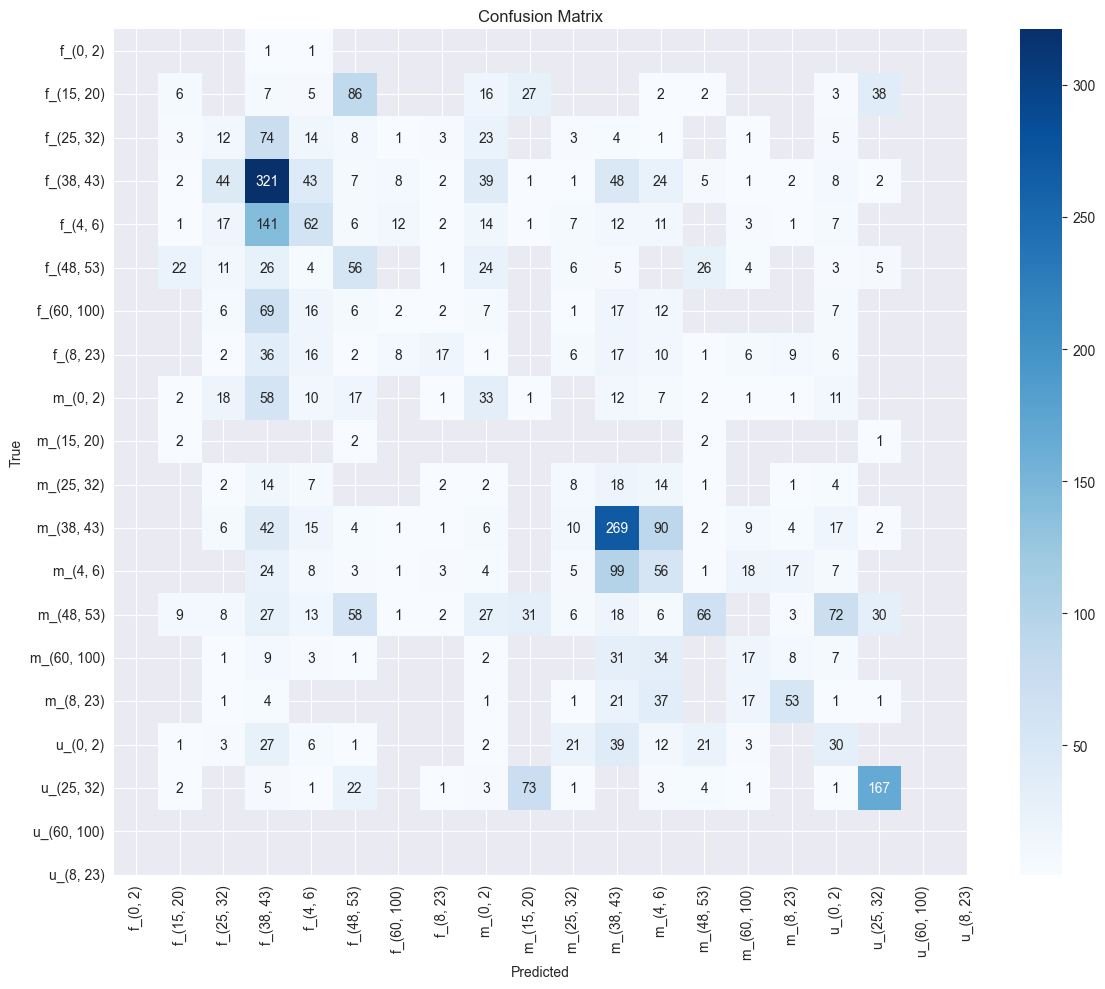

In [19]:
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, test_preds)
mask = cm == 0
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', mask=mask,
            xticklabels=gender_age_encoder.classes_,
            yticklabels=gender_age_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('improved_svc_confusion_matrix.png')
plt.show()

### Save the model

In [20]:
# Save the best model
joblib.dump(best_model, 'improved_svc_gender_age_classifier.joblib')
joblib.dump(gender_age_encoder, 'gender_age_encoder.joblib')
print("Model saved successfully.")

Model saved successfully.


In [21]:
# Define a function to predict gender_age for a new image
def predict_gender_age(image_path, model, gender_age_encoder):
    """Predict gender and age for a given face image."""
    # Extract features
    features = grayscale2emb([image_path]) / 255.0

    # Make prediction
    pred_class = model.predict(features)[0]

    # Get class probabilities
    pred_probs = model.predict_proba(features)[0]
    confidence = pred_probs[pred_class]

    # Convert to gender_age range
    pred_gender_age_range = gender_age_encoder.classes_[pred_class]

    return pred_gender_age_range, confidence